# Breaching privacy

This notebook does the same job as the cmd-line tool `breach.py`, but also directly visualizes the user data and reconstruction

In [1]:
import torch
import hydra
import copy
import numpy as np
from tqdm import tqdm
import seaborn as sns
import torch.nn as nn
from omegaconf import OmegaConf, open_dict
from torch.nn.functional import normalize
import scipy
from scipy import stats
%load_ext autoreload
%autoreload 2

import breaching
import logging, sys
logging.basicConfig(level=logging.INFO, handlers=[logging.StreamHandler(sys.stdout)], format='%(message)s')
logger = logging.getLogger()

### Initialize cfg object and system setup:

This will print out all configuration options. 
There are a lot of possible configurations, but there is usually no need to worry about most of these. Below, a few options are printed.

In [2]:
with hydra.initialize(config_path="config"):
    cfg = hydra.compose(config_name='cfg', overrides=['attack=clsattack'])
    cfg.case.server.name = 'class_malicious_parameters'
    print(f'Investigating use case {cfg.case.name} with server type {cfg.case.server.name}.')
          
device = torch.device(f'cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.backends.cudnn.benchmark = cfg.case.impl.benchmark
setup = dict(device=device, dtype=getattr(torch, cfg.case.impl.dtype))
setup

Investigating use case single_imagenet with server type class_malicious_parameters.


{'device': device(type='cuda'), 'dtype': torch.float32}

### Modify config options here

You can use `.attribute` access to modify any of these configurations:

In [3]:
with open_dict(cfg):
    cfg.case.data.partition = "feat_est"
    cfg.case.user.user_idx = 0
    cfg.case.user.num_data_points = 1
    cfg.case.model = 'resnet18'
    cfg.case.server.model_state = 'trained'
    cfg.case.user.provide_labels = True
    cfg.case.user.provide_buffers = True
    cfg.case.user.provide_num_data_points = True

    cfg.attack.optim.max_iterations = 0
    
    cfg.case.data.num_data_points = cfg.case.user.num_data_points
    cfg.case.data.target_label = 0
    
    cfg.case.data.name = "ImageNet"
    cfg.case.data.examples_from_split = "train"
    cfg.case.data.default_clients = 1000

### Instantiate all parties

In [4]:
user, server, model, loss_fn = breaching.cases.construct_case(cfg.case, setup)
attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)
breaching.utils.overview(server, user, attacker)

Model architecture resnet18 loaded with 11,380,173 parameters and 9,620 buffers.
Overall this is a data ratio of      76:1 for target shape [1, 3, 224, 224] given that num_queries=1.
User (of type UserSingleStep) with settings:
    Number of data points: 1

    Threat model:
    User provides labels: True
    User provides buffers: True
    User provides number of data points: True

    Data:
    Dataset: ImageNet
    user: 0
    
        
Server (of type ClassParameterServer) with settings:
    Threat model: Malicious (Parameters)
    Number of planned queries: 1
    Has external/public data: False

    Model:
        model specification: resnet18
        model state: trained
        public buffers: True

    Secrets: {}
    
Attacker (of type OptimizationBasedAttacker) with settings:
    Hyperparameter Template: invertinggradients

    Objective: Cosine Similarity with scale=1.0 and task reg=0.0
    Regularizers: Total Variation, scale=0.2. p=2 q=0.5. Color TV: double oppponents
    

In [5]:
print(user)
print(server)
print(attacker)

User (of type UserSingleStep) with settings:
    Number of data points: 1

    Threat model:
    User provides labels: True
    User provides buffers: True
    User provides number of data points: True

    Data:
    Dataset: ImageNet
    user: 0
    
        
Server (of type ClassParameterServer) with settings:
    Threat model: Malicious (Parameters)
    Number of planned queries: 1
    Has external/public data: False

    Model:
        model specification: resnet18
        model state: trained
        public buffers: True

    Secrets: {}
    
Attacker (of type OptimizationBasedAttacker) with settings:
    Hyperparameter Template: invertinggradients

    Objective: Cosine Similarity with scale=1.0 and task reg=0.0
    Regularizers: Total Variation, scale=0.2. p=2 q=0.5. Color TV: double oppponents
    Augmentations: 

    Optimization Setup:
        optimizer: adam
        signed: soft
        step_size: 0.1
        boxed: True
        max_iterations: 0
        step_size_decay: cos

### Simulate an attacked FL protocol

True user data is returned only for analysis

In [6]:
# modify the model to catch the class we want
cfg.case.data.target_label = 0

cls_to_obtain = cfg.case.data.target_label
extra_info = {'cls_to_obtain': cls_to_obtain}
server.reconfigure_model('cls_attack', extra_info=extra_info)

In [7]:
extra_info = {"cls_to_obtain": cls_to_obtain, "model": model, "loss_fn": loss_fn, "setup": setup}

In [ ]:
# # get gt_features:
# cfg.case.user.num_data_points = 1
# cfg.case.data.num_data_points = cfg.case.user.num_data_points
# gt_features, _ = server.estimate_feat(cfg, extra_info)

In [8]:
# get est_features:
cfg.case.user.num_data_points = 4
cfg.case.data.num_data_points = cfg.case.user.num_data_points
est_features, est_sample_sizes = server.estimate_feat(cfg, extra_info)

100%|██████████| 225/225 [16:00<00:00,  4.27s/it]


In [12]:
f_indx = server.find_best_feat(est_features, est_sample_sizes, method="kstest")

In [13]:
# print("True distribution")
# tmp_series = gt_features[f_indx]
# print(np.mean(tmp_series), np.std(tmp_series))

True distribution
0.72186613 0.43993247


In [13]:
print("Est distribution")
est_mean, est_std = server.estimate_gt_stats(est_features, est_sample_sizes, indx=f_indx)
print(est_mean, est_std)

Est distribution
1.7414173 0.979383833871355


In [32]:
# print("True distribution")
# sns.displot(tmp_series)

Est distribution


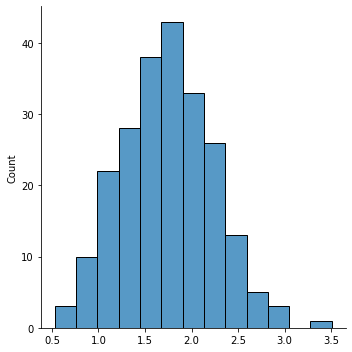

In [14]:
print("Est distribution")
sns.displot(est_features[f_indx])

### Now Attack

In [15]:
server.reset_model()
extra_info['multiplier'] = 300
extra_info["feat_to_obtain"] = f_indx
extra_info['feat_value'] = stats.norm.ppf(0.1, est_mean, est_std)
server.reconfigure_model('cls_attack', extra_info=extra_info)
server.reconfigure_model('feature_attack', extra_info=extra_info)

In [42]:
if cfg.case.data.examples_from_split == "validation":
    cfg.case.user.user_idx = 4
else:
    cfg.case.user.user_idx = 92

cfg.case.user.num_data_points = 10
cfg.case.data.num_data_points = cfg.case.user.num_data_points
user = breaching.cases.construct_user(model, loss_fn, cfg.case, setup)
server_payload = server.distribute_payload()
shared_data, true_user_data = user.compute_local_updates(server_payload)

In [44]:
attacker.objective.cfg_impl = cfg.attack.impl
single_gradients, single_losses = server.cal_single_gradients(attacker, true_user_data)
server.print_gradients_norm(single_gradients, single_losses)

grad norm         loss
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
13881.0625 77.02110290527344
0.0 0.0
0.0 0.0
1.0562740265784853e-10 0.0
0.0 0.0


In [45]:
server.model(true_user_data["data"])[:, [cls_to_obtain]]

tensor([[ 309.6493],
        [ 319.7330],
        [1542.5886],
        [  78.8295],
        [ 397.7830],
        [ -71.0394],
        [ 188.6521],
        [ 284.9042],
        [  28.8931],
        [ 262.8519]], device='cuda:0', grad_fn=<IndexBackward0>)

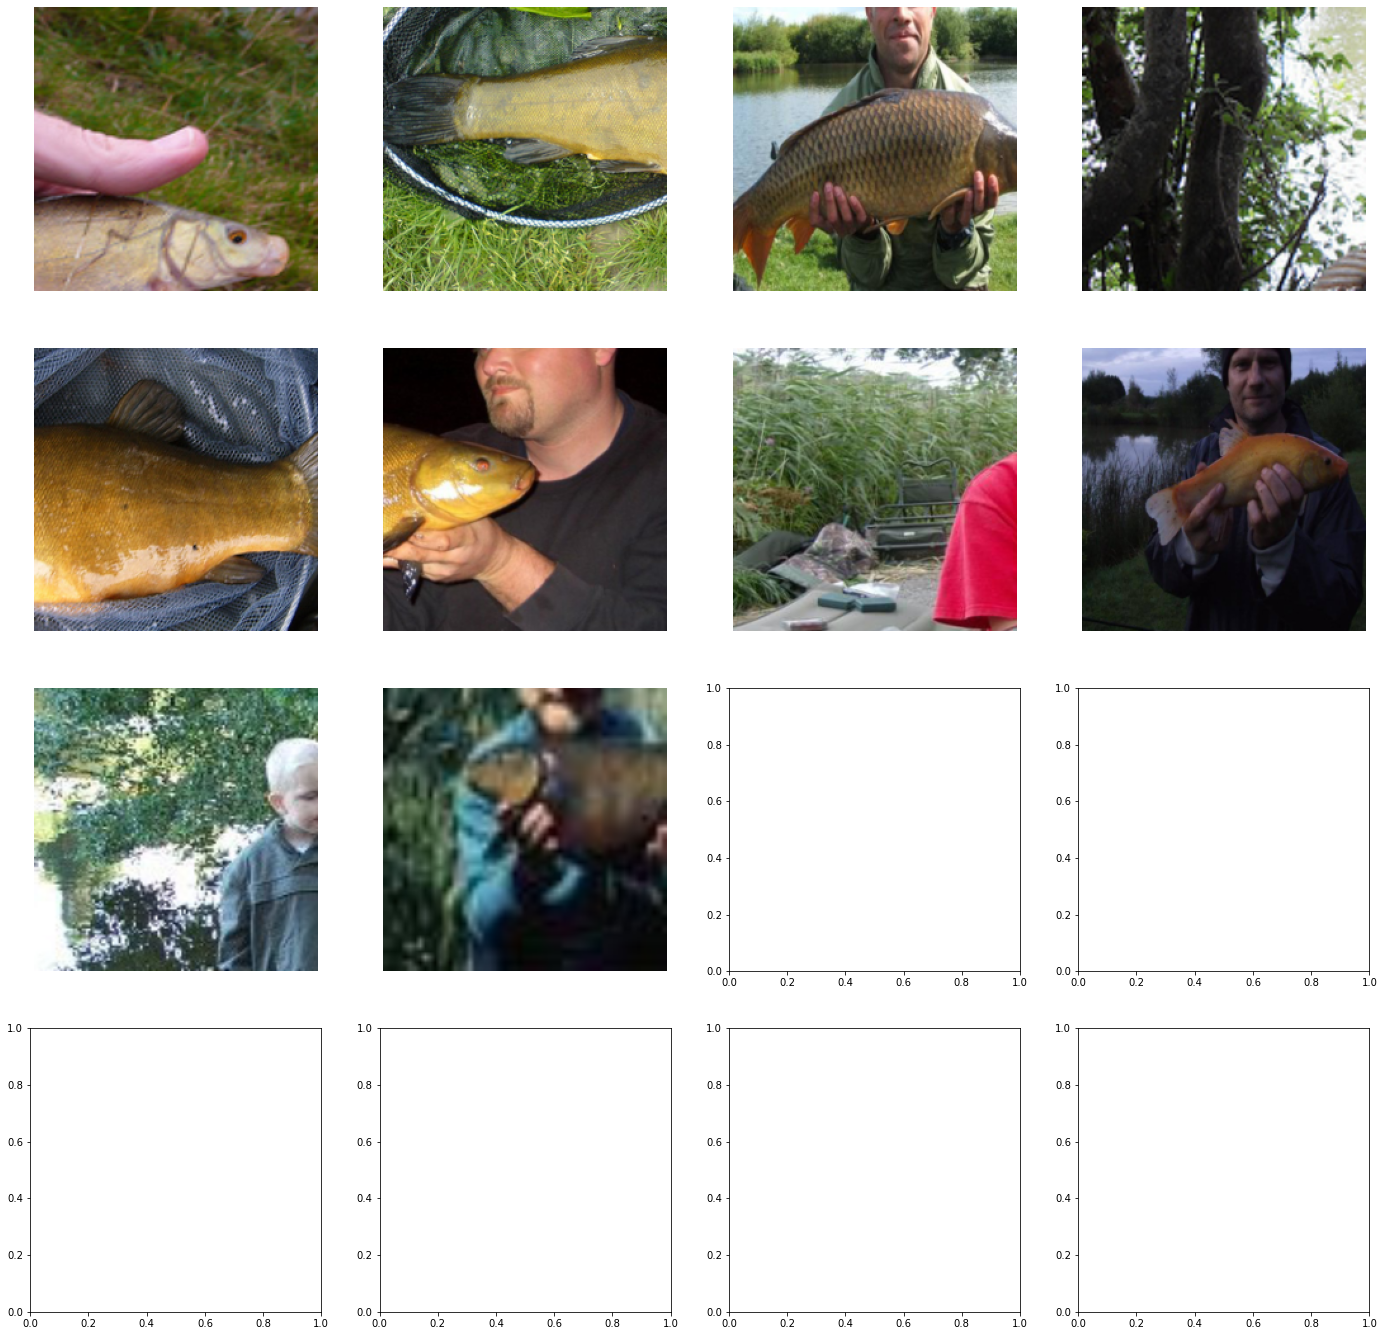

In [46]:
user.plot(true_user_data)